In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from pathlib import Path
from typing import Literal

from datautilities import meshmethods as mm
from datautilities import MeshIO as io

In [5]:
lr_res = "LR8_raw_6cpu"
hr_res = "HR_6cpu"
train_years = [1959, 1960, 1961, 1962, 1963]
test_years = 1964
root_dir = Path("../Data/Region1LR4/")

pred_path = "region1-lr8-migraphnet-59-60-61-62-63-15-5-wreg-hs-dir"

# lr_mesh = io.load_mesh(root_dir / "LR8_mesh.pickle")
mesh = io.load_mesh(root_dir / "HR_mesh.pickle")

In [3]:
# Load prediction
pred = np.load(root_dir / "predictions" / (pred_path + ".npy"))

# Get indices for coastline
coast_idx = mesh.get_node_indices_in_polygon(
    np.load("polygon_coastline_region1.npy")
)

In [4]:
class PreProcessing:
    def __init__(self):
        self.mean = None
        self.std = None

        self.pca = None

    @staticmethod
    def delete_nans(X: np.ndarray):
        """X has to be of shape (nsamples, nfeatures)"""
        nan_idx = np.nonzero(np.isnan(X).all(axis=0))[0]
        return np.delete(X, nan_idx, axis=1)

    def znormalize(self, X: np.ndarray):
        if self.mean is None or self.std is None:
            raise ValueError(
                ("Either 'self.mean or self.std is 'None'. Precompute them "
                 "by calling znormalize_fit first.")
            )
        return (X - self.mean) / self.std

    def znormalize_fit(self, X: np.ndarray):
        """Precompute mean and std of data set for later normalization"""
        self.mean = np.nanmean(X, axis=0)
        self.std = np.nanstd(X, axis=0)

    def pca_transform(self, X: np.ndarray):
        """Wrapper around sklearn's 'PCA.transform()' method"""
        if self.pca is None:
            raise ValueError(
                "No PCA instance found. Call pca_fit first to transform data."
            )
        return self.pca.transform(X)

    def pca_fit(self, X: np.ndarray, **kwargs):
        """Fit PCA instance. Kwargs are passed to pca initialization."""
        pca = PCA(**kwargs)
        self.pca = pca.fit(X)

    @staticmethod
    def polynomial_transform(X: np.ndarray, degree: int = 2):
        return PolynomialFeatures(degree=degree).fit_transform(X)

def preprocessing_pipeline(
    pp: PreProcessing,
    X: np.ndarray,
    y: np.ndarray,
    mode: Literal["train", "test"] = "train",
    delete_nans: bool = True,
    polynomials: int = 2,
    znormalize: bool = True,
    pca_transform: bool = True,
    **kwargs
) -> tuple[PreProcessing, np.ndarray, np.ndarray]:
    """Pipeline that processes input and target data. The preprocessing
    class stores the data that is necessary to perform later transforms.

    Parameters
    ----------
    pp : PreProcessing
        PreProcessing instance that is used to store or retrieve parameters
        to correctly preprocess the data
    X : np.ndarray
        Input data to be preprocessed. Assumed shape: (nsamples, nfeatures)
    y : np.ndarray
        Target data to be preprocessed. Assumed shape: (nsamples, nfeatures)
    mode : Literal['train', 'test'], optional
        If data should be fitted or just transformed, by default "train"
    delete_nans : bool
        If delete_nans should be called. Otherwise nan_to_num is used
        to treat nan data. By default True
    polynomials : int
        If 0, no polynomials are added. If > 0 then this is used as the
        degree of the polynomials. By default 0
    znormalize : bool
        If input should be znormalized, by default True
    pca_transform : bool
        If input should be pca-transformed, by default True
    **kwargs :
        Keyword arguments are passed to pca_fit

    Returns
    -------
    tuple[PreProcessing, np.ndarray, np.ndarray]
        Returns 'PreProcessing' instance with the stored parameters and the
        transformed inputs and targets
    """
    if delete_nans:
        X = pp.delete_nans(X)
        # y = pp.delete_nans(y)

        y = np.delete(y, np.load("../Data/Region1LR4/HR_6cpu/drop_index.npy"),
                      axis=1)
    else:
        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

    if polynomials:
        X = pp.polynomial_transform(X, degree=polynomials)

    if mode == "train":
        pp.znormalize_fit(X)
        pp.pca_fit(X, **kwargs)

    if znormalize:
        X = pp.znormalize(X)
    if pca_transform:
        X = pp.pca_transform(X)

    return pp, X, y


In [8]:
pp = PreProcessing()

X = mm.load_data(res=lr_res, years=train_years, root_dir=root_dir)

y = mm.load_data(res=hr_res, years=train_years, root_dir=root_dir)

kwargs = dict(
    delete_nans=True,
    polynomials=2,
    pca_transform=False,
    znormalize=False,
    whiten=False,
)

pp, X, y = preprocessing_pipeline(pp, X, y, **kwargs)

reg = Ridge(0.005, fit_intercept=False)
# reg = LinearRegression(fit_intercept=False)
reg = reg.fit(X, y)

X_test = mm.load_data(res=lr_res, years=test_years, root_dir=root_dir)
y_test = mm.load_data(res=hr_res, years=test_years, root_dir=root_dir)

pp, X_test, y_test = preprocessing_pipeline(
        pp, X_test, y_test, mode="test", **kwargs
    )

pred_lin = reg.predict(X_test)

/home/jannik/Documents/PhD/Super_Resolution_General/SROnUnstructuredGrids/datautilities/datautilities/meshmethods.py:106: RuntimeWarning: invalid value encountered in cast
  data[idx] = np.load(fpath).squeeze()
/home/jannik/anaconda3/envs/ugrid/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/jannik/Documents/PhD/Super_Resolution_General/SROnUnstructuredGrids/datautilities/datautilities/meshmethods.py:106: RuntimeWarning: invalid value encountered in cast
  data[idx] = np.load(fpath).squeeze()


In [ ]:
# Substitute the non-linear part with the predictions of the NN
# pred_hybrid = pred_lin.copy()
# pred_hybrid[:, coast_idx] = pred.reshape((-1, len(coast_idx)))

In [9]:
# pred = pred.reshape((-1, 2448))
pred = pred.reshape((-1, 2338))

In [10]:
y_test[y_test == 0] = np.nan

print("Purely linear model")
print("-------------------")
print("MAE:", np.nanmean(np.abs(pred_lin - y_test)))
print("MSE:", np.nanmean(np.abs(pred_lin - y_test)**2))
print("Max:", np.nanmax(np.abs(pred_lin - y_test)))
print("Hybrid linear NN model")
print("-------------------")
print("MAE:", np.nanmean(np.abs(pred - y_test)))
print("MSE:", np.nanmean(np.abs(pred - y_test)**2))
print("Max:", np.nanmax(np.abs(pred - y_test)))

Purely linear model
-------------------
MAE: 0.013168640011702657
MSE: 0.00042112033369118447
Max: 0.2480296468177059
Hybrid linear NN model
-------------------
MAE: 0.011269385565525954
MSE: 0.0003218639066103781
Max: 0.2376384735107422


# Plot error distribution over different wave heights

In [11]:
# y_test = y_test[:, coast_idx]

# diff_lin = np.abs(pred_lin[:, coast_idx] - y_test).flatten()
# diff = np.abs(pred[:, coast_idx] - y_test).flatten()
diff_lin = np.abs(pred_lin - y_test).flatten()
diff = np.abs(pred - y_test).flatten()

In [12]:
print(np.nanmean(diff_lin))
print(np.nanmean(diff))
print(np.nanmean(diff_lin**2))
print(np.nanmean(diff**2))

0.013168640011702657
0.011269385565525954
0.00042112033369118447
0.0003218639066103781


In [13]:
# Create the boxes to put the results into
cond = ~np.isnan(y_test.flatten())

# y_max = np.nanmax(y_test)
# y_min = np.nanmin(y_test)

# cts, edges = np.histogram(y_test.flatten()[cond], nbins, (y_min, y_max))
# Create evenly spaced edges
edges = np.arange(0, 4.6, 0.5)

errors_lin = []
errors = []

for i in range(len(edges) - 1):
    range_mask = (edges[i] <= y_test.flatten()) & (y_test.flatten() < edges[i+1])

    errors_lin.append(diff_lin[range_mask])
    errors.append(diff[range_mask])

In [14]:
labels = []
for i in range(len(edges)-1):
    labels.append(f"{edges[i]}m\n-{edges[i+1]}m")

labels[0] = "<0m"
labels[-1] = ">4m"

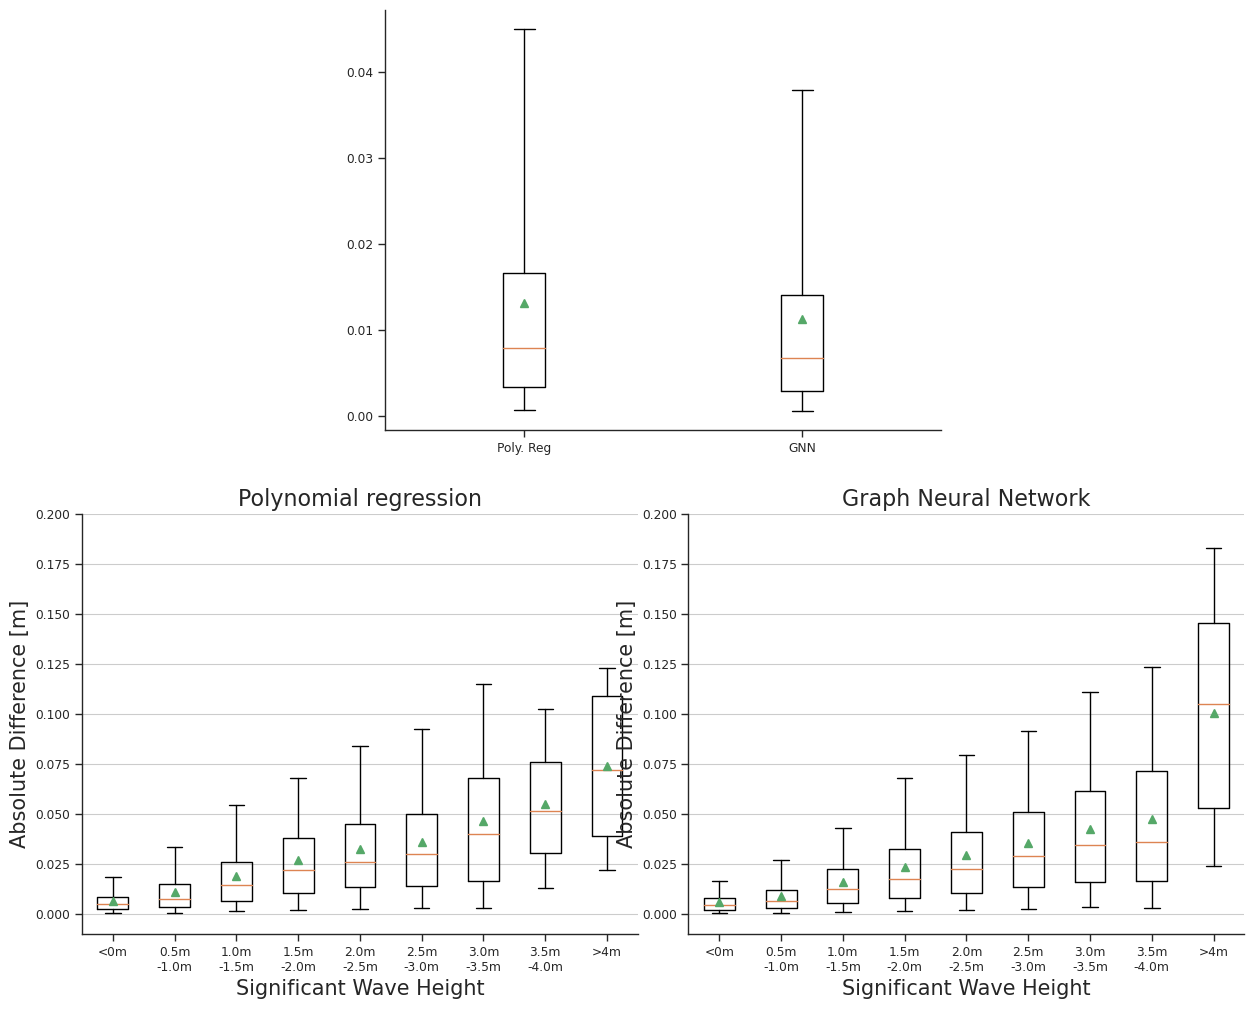

In [23]:
mosaic = [[".", "all", "all", "."],
          ["pr", "pr", "gn", "gn"]]

fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(15, 12))

sns.set_theme(context="paper", style="ticks")
sns.despine()

plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 15

axs["all"].boxplot([diff_lin, diff], whis=(5, 95), sym="",
                   labels=["Poly. Reg", "GNN"], showmeans=True,
                   meanline=False)

axs["pr"].boxplot(errors_lin, whis=(5, 95), sym="", labels=labels,
               showmeans=True, meanline=False)

axs["gn"].boxplot(errors, whis=(5, 95), sym="", labels=labels,
               showmeans=True, meanline=False)

axs["pr"].grid(axis="y")
axs["gn"].grid(axis="y")

axs["pr"].set_ylim(-0.01, 0.2)
axs["gn"].set_ylim(-0.01, 0.2)

axs["pr"].set_title("Polynomial regression")
axs["gn"].set_title("Graph Neural Network")

axs["pr"].set_ylabel("Absolute Difference [m]")
axs["gn"].set_ylabel("Absolute Difference [m]")

axs["pr"].set_xlabel("Significant Wave Height")
axs["gn"].set_xlabel("Significant Wave Height")

# fig.suptitle("Region 1", size=18)

out_path = Path("plots") / "region1" / "error-distribution-5years"
out_path.parent.mkdir(exist_ok=True, parents=True)
# plt.savefig(out_path, dpi=300, bbox_inches="tight")

plt.show()